<a href="https://colab.research.google.com/github/AbdalrahmanAliElnashar/NLP/blob/main/Emotion_Detection_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



## Access dataset


In [ ]:
test_data = pd.read_csv("/content/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("/content/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/validation.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


## Print subset of dataset

In [ ]:
train_data.head(10)

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


### Try to find if there is a correlation between emotion and comments length !!

In [ ]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()


,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


### Some plots to understand data frequencies

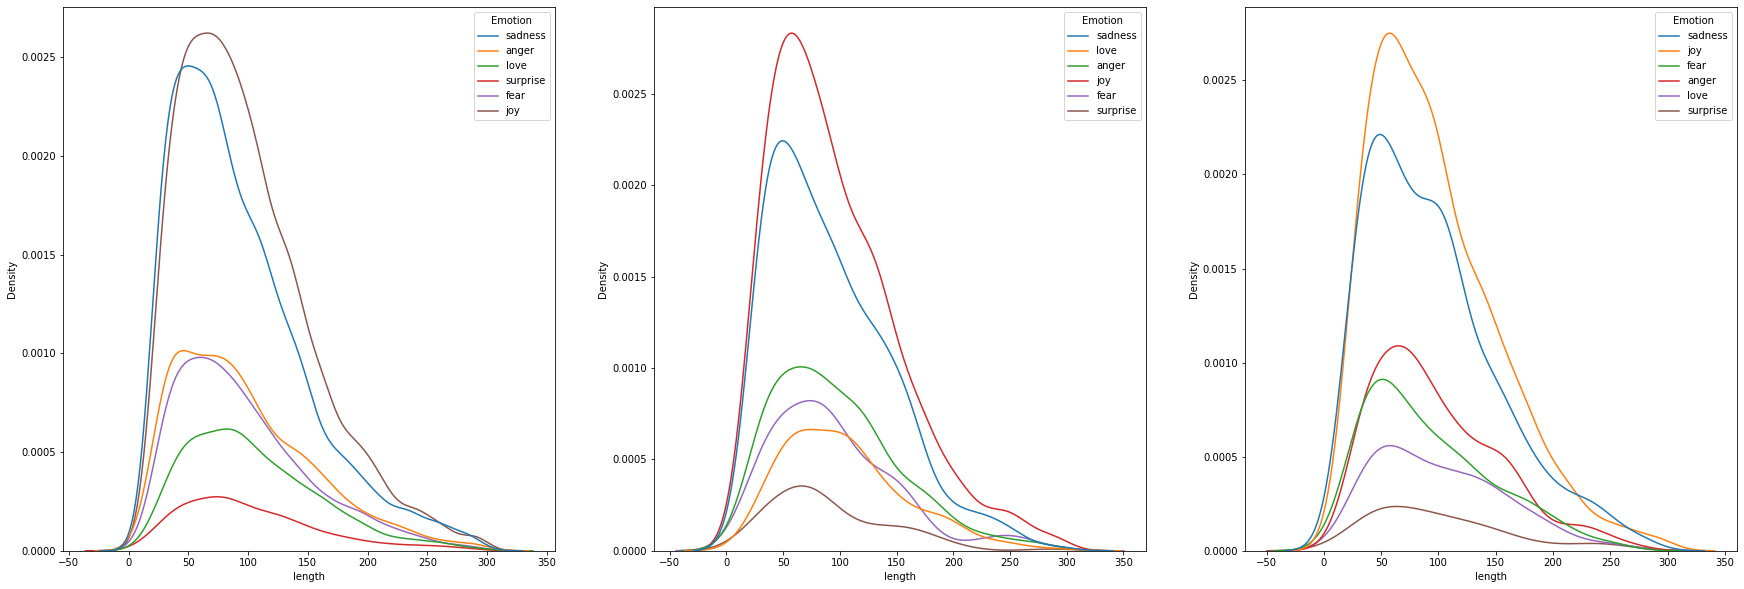

In [ ]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

### Using WordClound library to visualize words

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


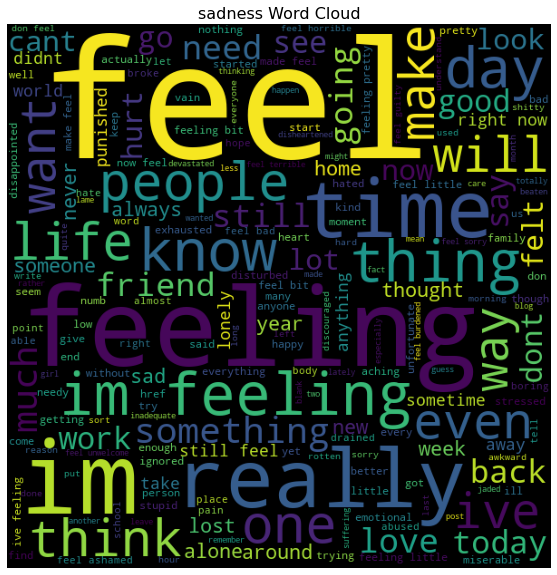

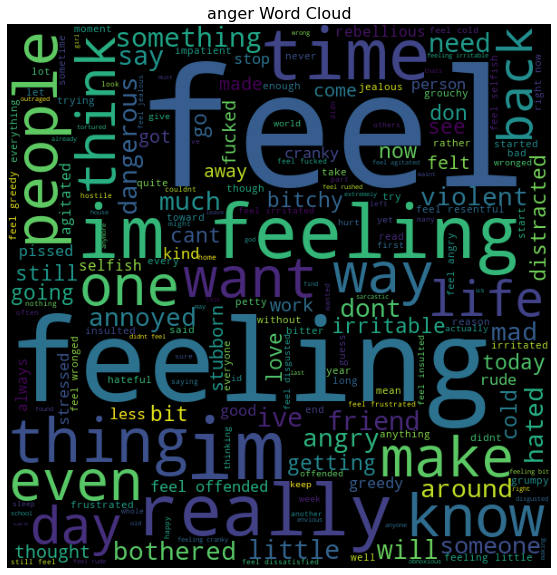

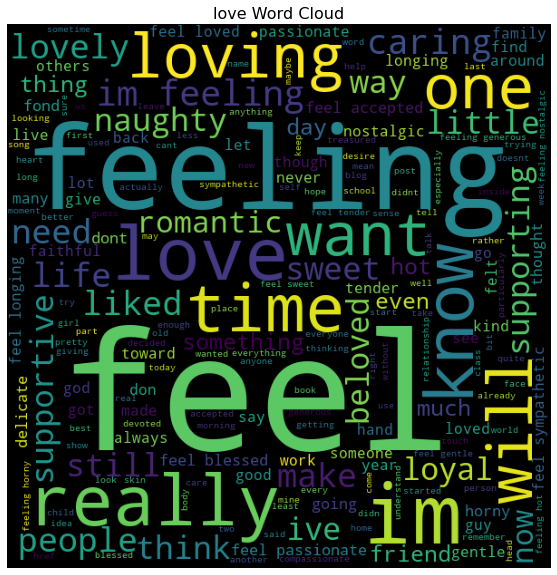

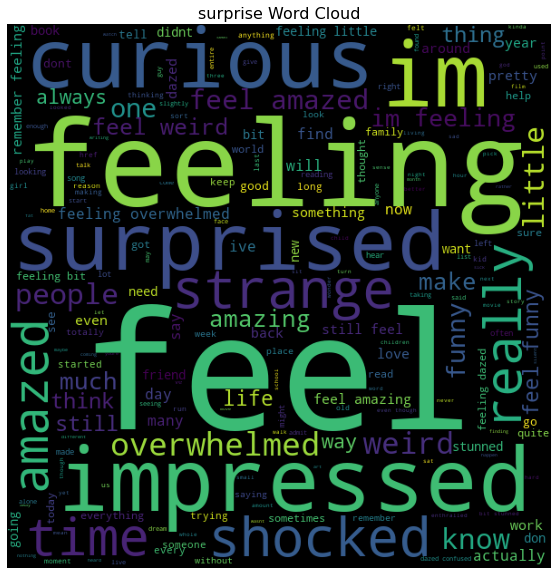

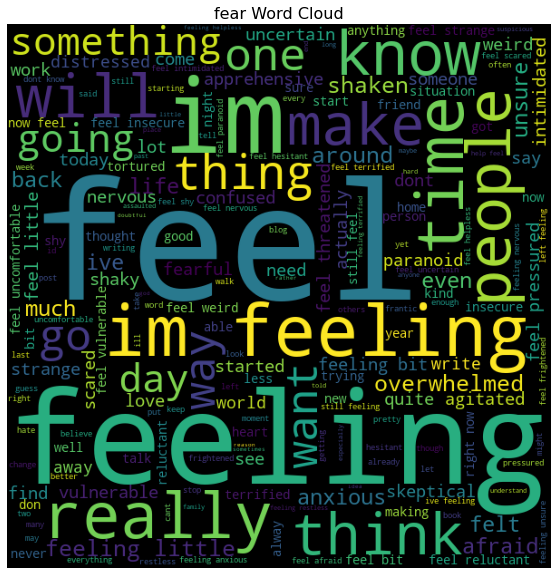

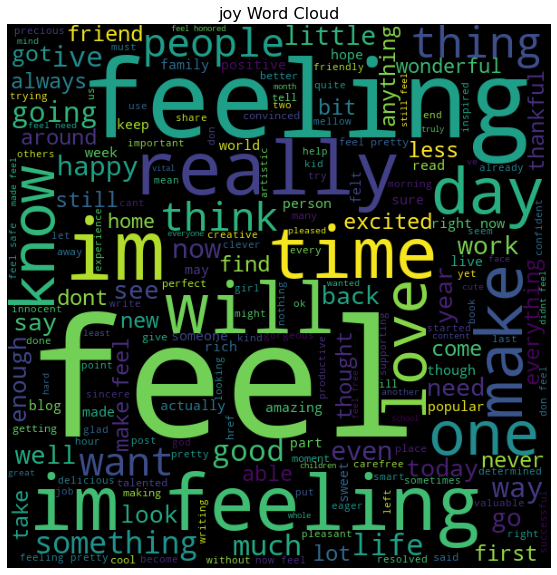

In [ ]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# print unique emotions
emotions_list = train_data['Emotion'].unique()
print(emotions_list)
for emotion in emotions_list:
      text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
      wordcloud = WordCloud(width = 600, height = 600).generate(text)
      words_cloud(wordcloud, emotion)

    

## Label Enconding

In [ ]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

train_data.head(10)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
5,ive been feeling a little burdened lately wasn...,4,65
6,ive been taking or milligrams or times recomme...,5,122
7,i feel as confused about life as a teenager or...,1,73
8,i have been with petronas for years i feel tha...,2,98
9,i feel romantic too,3,19


In [ ]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
max_len=train_data['length'].max()
max_len


300

In [ ]:
vocabSize = 11000

## Removing unrelevent chars, Stemming and padding

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
   
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [ ]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [ ]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Building Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [ ]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)


In [ ]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 172s 679ms/step - loss: 1.4170 - accuracy: 0.4322 - val_loss: 0.9113 - val_accuracy: 0.6760
Epoch 2/10
250/250 [==============================] - 169s 676ms/step - loss: 0.6610 - accuracy: 0.7588 - val_loss: 0.5074 - val_accuracy: 0.8380
Epoch 3/10
250/250 [==============================] - 168s 670ms/step - loss: 0.3400 - accuracy: 0.8882 - val_loss: 0.3698 - val_accuracy: 0.8715
Epoch 4/10
250/250 [==============================] - 167s 670ms/step - loss: 0.2190 - accuracy: 0.9283 - val_loss: 0.3615 - val_accuracy: 0.8775
Epoch 5/10
250/250 [==============================] - 167s 670ms/step - loss: 0.1691 - accuracy: 0.9417 - val_loss: 0.3653 - val_accuracy: 0.8805
Epoch 6/10
250/250 [==============================] - 168s 671ms/step - loss: 0.1352 - accuracy: 0.9526 - val_loss: 0.3638 - val_accuracy: 0.8775


In [ ]:
model.evaluate(x_val,y_val,verbose=1)


63/63 [==============================] - 5s 82ms/step - loss: 0.3615 - accuracy: 0.8775


[0.3614920973777771, 0.8774999976158142]

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 5s 83ms/step - loss: 0.3931 - accuracy: 0.8580


[0.3930636942386627, 0.8579999804496765]

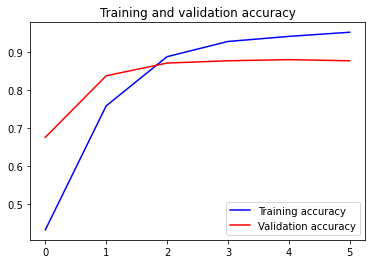

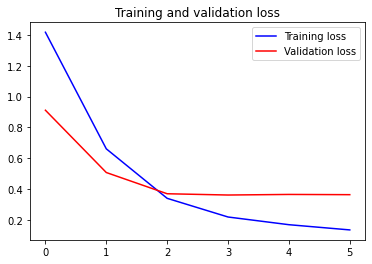

In [ ]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [ ]:
sentences = [
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He was speechles when he found out he was accepted to this new job
joy : 0.27414268255233765


This is outrageous, how can you talk like that?
anger : 0.8083556890487671


I feel like im all alone in this world
sadness : 0.9573184251785278


He is really sweet and caring
love : 0.8354848623275757


